In [12]:
import os.path
import sys
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from imageio import imsave
from torch.utils import model_zoo

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from building_footprint_segmentation.seg.binary.models import ReFineNet
from building_footprint_segmentation.helpers.normalizer import min_max_image_net
from building_footprint_segmentation.utils.py_network import (
    to_input_image_tensor,
    add_extra_dimension,
    convert_tensor_to_numpy,
    load_parallel_model,
    adjust_model,
)
from building_footprint_segmentation.utils.operations import handle_image_size

In [13]:
MAX_SIZE = 384
TRAINED_MODEL = ReFineNet()

PRED_PTH = r"/home/ippws/building-footprint-segmentation/data/rio/building_patches/test/images/2350_RJ286D2.tif"

In [14]:
CUSTOM_WEIGHTS = r"/home/ippws/building-footprint-segmentation/logs/mass_building_seg/finalversionrio_resnet50_batchs16_th.45epch100/state/best.pt"

# ROCm-compatible device check
if torch.backends.mps.is_available():   # Apple Silicon
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():         # NVIDIA CUDA
    DEVICE = torch.device("cuda")
elif torch.version.hip is not None and torch.cuda.is_available():  # AMD ROCm
    DEVICE = torch.device("cuda")  # ROCm exposes as 'cuda' but backed by HIP
else:
    DEVICE = torch.device("cpu")

print("Using device:", DEVICE)

TRAINED_MODEL = ReFineNet().to(DEVICE)

def set_model_weights():
    state_dict = torch.load(CUSTOM_WEIGHTS, map_location=DEVICE, weights_only=False)
    if "model" in state_dict:
        state_dict = state_dict["model"]

    
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith('module.'):
            new_key = key[7:]  # Remove 'module.' prefix
            new_state_dict[new_key] = value
        else:
            new_state_dict[key] = value
    

    
    # This should now work without errors
    missing, unexpected = TRAINED_MODEL.load_state_dict(new_state_dict, strict=False)



    #TRAINED_MODEL.load_state_dict(adjust_model(state_dict))
    TRAINED_MODEL.eval()
    

def extract(original_image):
    original_height, original_width = original_image.shape[:2]
    
    if (original_height, original_width) != (MAX_SIZE, MAX_SIZE):
        original_image = handle_image_size(original_image, (MAX_SIZE, MAX_SIZE))
    

    normalized_image = original_image.astype(np.float32) / 255.0
    

    
    tensor_image = add_extra_dimension(to_input_image_tensor(normalized_image))

    tensor_image = tensor_image.to(DEVICE)
    
    with torch.no_grad():
        prediction = TRAINED_MODEL(tensor_image)
        
        
        prediction = prediction.sigmoid()
        
        prediction_np = prediction.cpu().numpy()
    
    prediction_binary = prediction_np[0, 0]
    

    # Threshold
    prediction_binary_thresh = (prediction_binary > 0.5).astype(np.uint8) * 255
    
    prediction_3_channels = cv2.cvtColor(prediction_binary_thresh, cv2.COLOR_GRAY2BGR)
    
    dst = cv2.addWeighted(original_image, 1, prediction_3_channels, 0.4, 0)
    
    return prediction_binary_thresh, prediction_3_channels, dst

    #TRAINED_MODEL.load_state_dict(adjust_model(state_dict))

Using device: cuda


In [15]:
def run(image_path):
    original_image = cv2.imread(image_path)
# DEBUG: Check the loaded image


    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    set_model_weights()
    # PARALLELIZE the model if gpu available
    # model = load_parallel_model(model)

    prediction_binary, prediction_3_channels, dst = extract(original_image)
    # imsave(f"{os.path.basename(image_path)}", prediction_binary)
    return prediction_binary, prediction_3_channels, dst

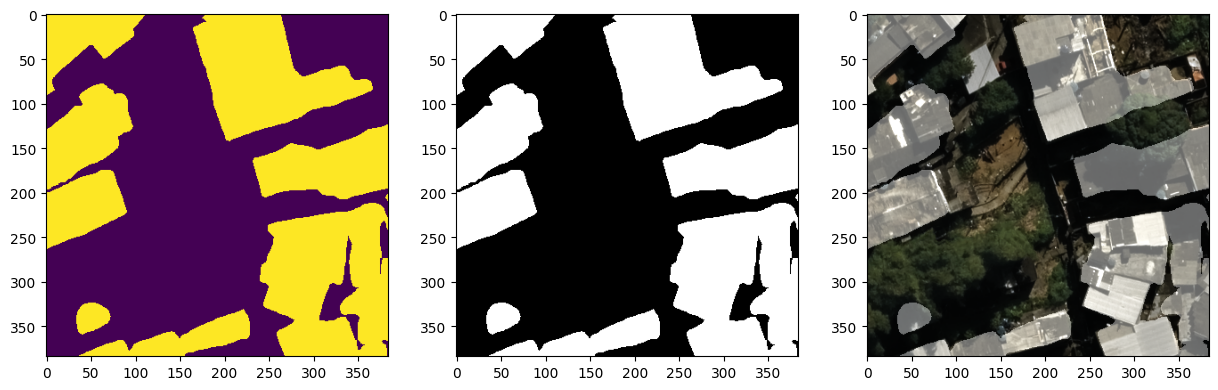

In [16]:
pred = run(PRED_PTH)

fig,ax = plt.subplots(1,3,figsize = (15,15))
ax = ax.ravel()
for i in range(3):
  image = pred[i]
  ax[i].imshow(image)  
plt.show()